In [305]:

# Combine all of csv files of tweets for different months into one csv file 
import os
import pandas as pd
# specify the directory where the csv files are located
path = r"C:\Users\myloe\OneDrive\Desktop\Sentiment_analysis-1\New folder"

# get a list of all the csv files in the directory
files = os.listdir(path)
csv_files = [file for file in files if file.endswith('.csv')]

# create an empty DataFrame to store the combined data
df_combined = pd.DataFrame()
 
 
# loop through each csv file and read its contents into a DataFrame
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(path, csv_file))
    df_combined = pd.concat([df_combined, df], ignore_index=True)

# write the combined data to a new csv file
df_combined.to_csv("2010-2021.csv", index=False)



In [306]:
import pandas as pd
import csv
import re 
import string
import http.client, urllib
from datetime import datetime, timedelta
import pytz
import nltk
import spacy
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
import gensim.models
import sklearn
import sklearn.decomposition


# Read the CSV file into a DataFrame
filtered_df1=pd.read_csv(r'C:\Users\myloe\OneDrive\Desktop\Sentiment_analysis-1\2010-2021.csv')

filtered_df1.shape



(551321, 13)

### let's take a look at first few row of our dataset

In [307]:
filtered_df1.head()

author_id         username  author_followers  author_tweets  \
0   15499851  Posh_CoutureCom              4708          31632   
1   33275477  DIY_Doll_Crafts              3503          49566   
2   15499820    BestDealsMall              2571          40272   
3   90466286   GetOutfitIdeas              3986          32388   
4   30837040       azInternet              6682          43391   

                                  author_description  \
0  http://t.co/NQ9l2aR3VF . Buy all items over th...   
1  I will show you  DIY Miniature Dollhouse Room,...   
2  Best deals of  the day from AMAZON, Today's Ho...   
3  Buy online best Outfit Ideas from UK, France, ...   
4  I LOVE things from internet! Fashion, Beauty, ...   

                author_location  \
0  Chicago, London, Dubai, Doha   
1                 New York, USA   
2                     New York    
3              London, New York   
4                      New York   

                                                text  \
0  Short Sales Insider Guide - Big Profits In A C...   
1  Short Sales Insider Guide - Big Profits In A C...   
2  Short Sales Insider Guide - Big Profits In A C...   
3  Short Sales Insider Guide - Big Profits In A C...   
4  Short Sales Insider Guide - Big Profits In A C...   

                  created_at  retweets  replies  likes  quote_count  \
0  2010-03-01 23:35:05+00:00         0        0      0            0   
1  2010-03-01 23:35:03+00:00         0        0      0            0   
2  2010-03-01 23:34:57+00:00         0        0      0            0   
3  2010-03-01 23:34:55+00:00         0        0      0            0   
4  2010-03-01 23:34:53+00:00         0        0      0            0   

   Unnamed: 0  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [308]:
filtered_df1['text'].head()

0    Short Sales Insider Guide - Big Profits In A C...
1    Short Sales Insider Guide - Big Profits In A C...
2    Short Sales Insider Guide - Big Profits In A C...
3    Short Sales Insider Guide - Big Profits In A C...
4    Short Sales Insider Guide - Big Profits In A C...
Name: text, dtype: object

## we need to do cleaning on text column of dataset which includes the collected tweets. We will try to eliminate some characters that doesn't have any effect on the sentiment of tweet such as email address, or punctuations.

In [309]:
filtered_df1['username'].value_counts()

twinsmoneytips     6960
LAmortgagehelp     5980
EINRealEstate      5894
usaregnews         5850
Cash4RESellers     4657
                   ... 
ITVCymruWales         1
ceciliaplummer        1
carochavezphoto       1
LesleyGleason         1
RippleDeGad           1
Name: username, Length: 97228, dtype: int64

### ~550000 tweets has been created by 97228 users. it shows most of the tweet has been created by bots. we will try to remove them in the next cell.

In [310]:

# Convert the created_at column to a datetime type
filtered_df1['created_at'] = pd.to_datetime(filtered_df1['created_at'], format='%Y-%m-%d %H:%M:%S%z')

# Extract the year and month from the created_at column
filtered_df1['year_month'] = filtered_df1['created_at'].dt.to_period('M')

# Group the data by username and year_month and count the number of tweets for each group
grouped = filtered_df1.groupby(['username', 'year_month']).size().reset_index(name='count')

# Filter the groups that have a count greater than 2
filtered = grouped[grouped['count'] > 2]

# Keep only the tweets from usernames that have a count less than or equal to 2
filtered_df1 = filtered_df1[~filtered_df1['username'].isin(filtered['username'])]

# Drop the year_month column since it's not needed anymore
filtered_df = filtered_df1.drop(columns=['year_month'])

# Save the resulting DataFrame to a new CSV file
filtered_df.to_csv("filtered_dataset.csv", index=False)

filtered_df.shape

C:\Users\myloe\AppData\Local\Temp\ipykernel_20616\470067452.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df1['year_month'] = filtered_df1['created_at'].dt.to_period('M')


PermissionError: [Errno 13] Permission denied: 'filtered_dataset.csv'

In [ ]:
# missing values
filtered_df.isnull().sum()

author_id                  0
username                   0
author_followers           0
author_tweets              0
author_description     13237
author_location         7905
text                       0
created_at                 0
retweets                   0
replies                    0
likes                      0
quote_count                0
Unnamed: 0            115232
dtype: int64

In [ ]:
# drop the rows with msissing values for author_location since we will need author location later
filtered_df.dropna(subset=['author_location'], inplace=True)

### One thing we should think about is how many of our tweets are actually unique because people retweet each other and so there could be multiple copies of the same tweet. 

In [ ]:
filtered_df.text.unique().shape

(153982,)

In [ ]:
filtered_df.text.shape

(159069,)

In [ ]:
### above results show that 159069-153982=5087 tweets are duplicate.Since the number of retweets is not significantly high so we will keep them.

In [ ]:
# make a new column to highlight retweets
filtered_df['is_retweet'] = filtered_df['text'].apply(lambda x: x[:2]=='RT')
filtered_df['is_retweet'].sum()


2252

In [ ]:
 # number of unique retweets
 filtered_df.loc[filtered_df['is_retweet']].text.unique().size

2144

In [ ]:
#removing URls & Email Addresses
import re

def remove_urls_and_emails(text):
    # Remove URLs
    text = re.sub(r"\S*https?:\S*", " ", text)
    # Remove email addresses
    text = re.sub(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", " ", text)
    return text

filtered_df.text = filtered_df.text.apply(lambda x: remove_urls_and_emails(x))


#Fixing Contractions
import contractions
def fix_contract(textcont):
    textfix=contractions.fix(textcont)
    return textfix
filtered_df.text=filtered_df.text.apply(lambda x: fix_contract(x))


# remove hashtags
# only removing the hash # sign from the word
import re
def hash_remove(texthash):
    textunhash=re.sub(r'#', ' ', texthash)
    return textunhash
filtered_df.text = filtered_df.text.apply(lambda x: hash_remove(x))


#remove words starting with @. these are user ids that are mentioned in tweets
filtered_df['text'] = filtered_df['text'].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

In [ ]:
# let's take a look at first few rows of text column after doing some cleaning
filtered_df1['text'].head()

5     Warren Buffett sees housing market bouncing ba...
8     COME CHECK OUT MY BLOG!  Local &national news ...
11    RT: @RealEstateIQ ReturnRealEstate.com Buffett...
12    Warren Buffett sees housing market bouncing ba...
19    Buffett: Housing market to rebound in a year |...
Name: text, dtype: object

In [ ]:
#dictionary consisting of apostrphe's

import re
def s_remove(texts):
    textuns=re.sub(r"'s", ' ', texts)
    return textuns
filtered_df.text = filtered_df.text.apply(lambda x: s_remove(x))



#dictionary consisting of apostrphe’s is

import re
def is_fix(textunis):
    textis=re.sub(r"’s", ' ', textunis)
    return textis
filtered_df.text = filtered_df.text.apply(lambda x: is_fix(x))

#punctuation

import re
def punc_fix(textpun):
    textunpun=re.sub(r'[^\w\s]', ' ', textpun)
    return textunpun
filtered_df.text = filtered_df.text.apply(lambda x: punc_fix(x))


In [ ]:
# Replace all of the digits in the string with an empty string.
import re
def num_fix(textnum):
    textnonum=re.sub(r'[0-9]', ' ', textnum)
    return textnonum
filtered_df.text = filtered_df.text.apply(lambda x: num_fix(x))


# remove whitespace
def removewh(textwh):
    return " ".join(textwh.split())
filtered_df.text = filtered_df.text.apply(lambda x: removewh(x))


# return all words in lowercase
def lowercase(textU):
    return textU.lower()
filtered_df.text = filtered_df.text.apply(lambda x: lowercase(x))


#Drop repeated tweets (keep the original one)
filtered_df = filtered_df.drop_duplicates(subset ="text", keep = "first")
filtered_df.text


5         warren buffett sees housing market bouncing ba...
8         come check out my blog local national news aff...
11        rt returnrealestate com buffett says us housin...
12        warren buffett sees housing market bouncing ba...
19        buffett housing market to rebound in a year th...
                                ...                        
548314    remember when bear sterns crashed leading to t...
548315    what does the coming year hold for the housing...
548321    does anyone have a good rabbit hole for me to ...
548328    eli knows the miami real estate market like th...
548334    here are the top realestate market predictions...
Name: text, Length: 120089, dtype: object

In [ ]:
#Tokenize & remove unnecessary PoS and words from stop list
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag  # for pos_tag function

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')  # for pos_tag function

# Bring in the default English NLTK stop words
stoplist = stopwords.words('english')

# Open a file and read it into memory
file = open(r'C:\Users\myloe\OneDrive\Desktop\Additional stop words.txt')
texti = file.read()


# Apply the stoplist to the text
additional_stopwords = [word for word in texti.split() if word not in stoplist]
stoplist += additional_stopwords
stoplist = [word.lower() for word in stoplist]
additional_stopwords = [word.lower() for word in additional_stopwords]

for i in range(len(stoplist)):
    stoplist[i] = stoplist[i].lower()


def token(textUnT):
    text_tokens = word_tokenize(textUnT)
    # Tag the parts of speech of the tokens
    pos_tags = pos_tag(text_tokens)
    # Keep only the words that are verbs, nouns, adjectives, or adverbs
    tokens = [word for word, tag in pos_tags if tag in ['NN','NNS']]
    # Remove stop words and return the filtered list of tokens
    tokens_without_sw = [word for word in tokens if not word in stoplist]
    return tokens_without_sw

filtered_df.text = filtered_df.text.apply(lambda x: token(x))

#lemmatize using Spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return lemmas

filtered_df.text = filtered_df.text.apply(lambda x: lemmatize_tokens(x))


# Untokenize
def token_join(tokens):
    text_untok = " ".join(tokens)
    return text_untok
filtered_df.text = filtered_df.text.apply(lambda x: token_join(x))
filtered_df.text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myloe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\myloe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


5                                                       see
8                                 check news listing update
11                                 returnrealestate buffett
12                                          see billionaire
19                                                deal news
                                ...                        
548314                   sterns catastrophe governor crisis
548315    hold mortgage rate price expert buyer demand p...
548321                             rabbit hole confirmation
548328    experience bio panfloridarealty knockhomeswap ...
548334                           prediction business biztip
Name: text, Length: 120089, dtype: object

In [ ]:
#Run tokenization and removing stop words again after lemmatization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Bring in the default English NLTK stop words
stoplist = stopwords.words('english')

# Open a file and read it into memory
file = open(r'C:\Users\myloe\OneDrive\Desktop\Additional stop words.txt')
texti = file.read()
# Apply the stoplist to the text
additional_stopwords = [word for word in texti.split() if word not in stoplist]
stoplist += additional_stopwords
stoplist = [word.lower() for word in stoplist]
additional_stopwords = [word.lower() for word in additional_stopwords]

for i in range(len(stoplist)):
    stoplist[i] = stoplist[i].lower()

def token(textUnT):
    text_tokens = word_tokenize(textUnT)
    # Remove stop words and return the filtered list of tokens
    tokens_without_sw = [word for word in text_tokens if not word in stoplist]
    return tokens_without_sw

filtered_df.text = filtered_df.text.apply(lambda x: token(x)) 
filtered_df.text


5                                                        []
8                                    [check, news, listing]
11                              [returnrealestate, buffett]
12                                            [billionaire]
19                                             [deal, news]
                                ...                        
548314              [sterns, catastrophe, governor, crisis]
548315    [hold, mortgage, rate, price, expert, buyer, d...
548321                         [rabbit, hole, confirmation]
548328    [experience, bio, panfloridarealty, knockhomes...
548334                       [prediction, business, biztip]
Name: text, Length: 120089, dtype: object

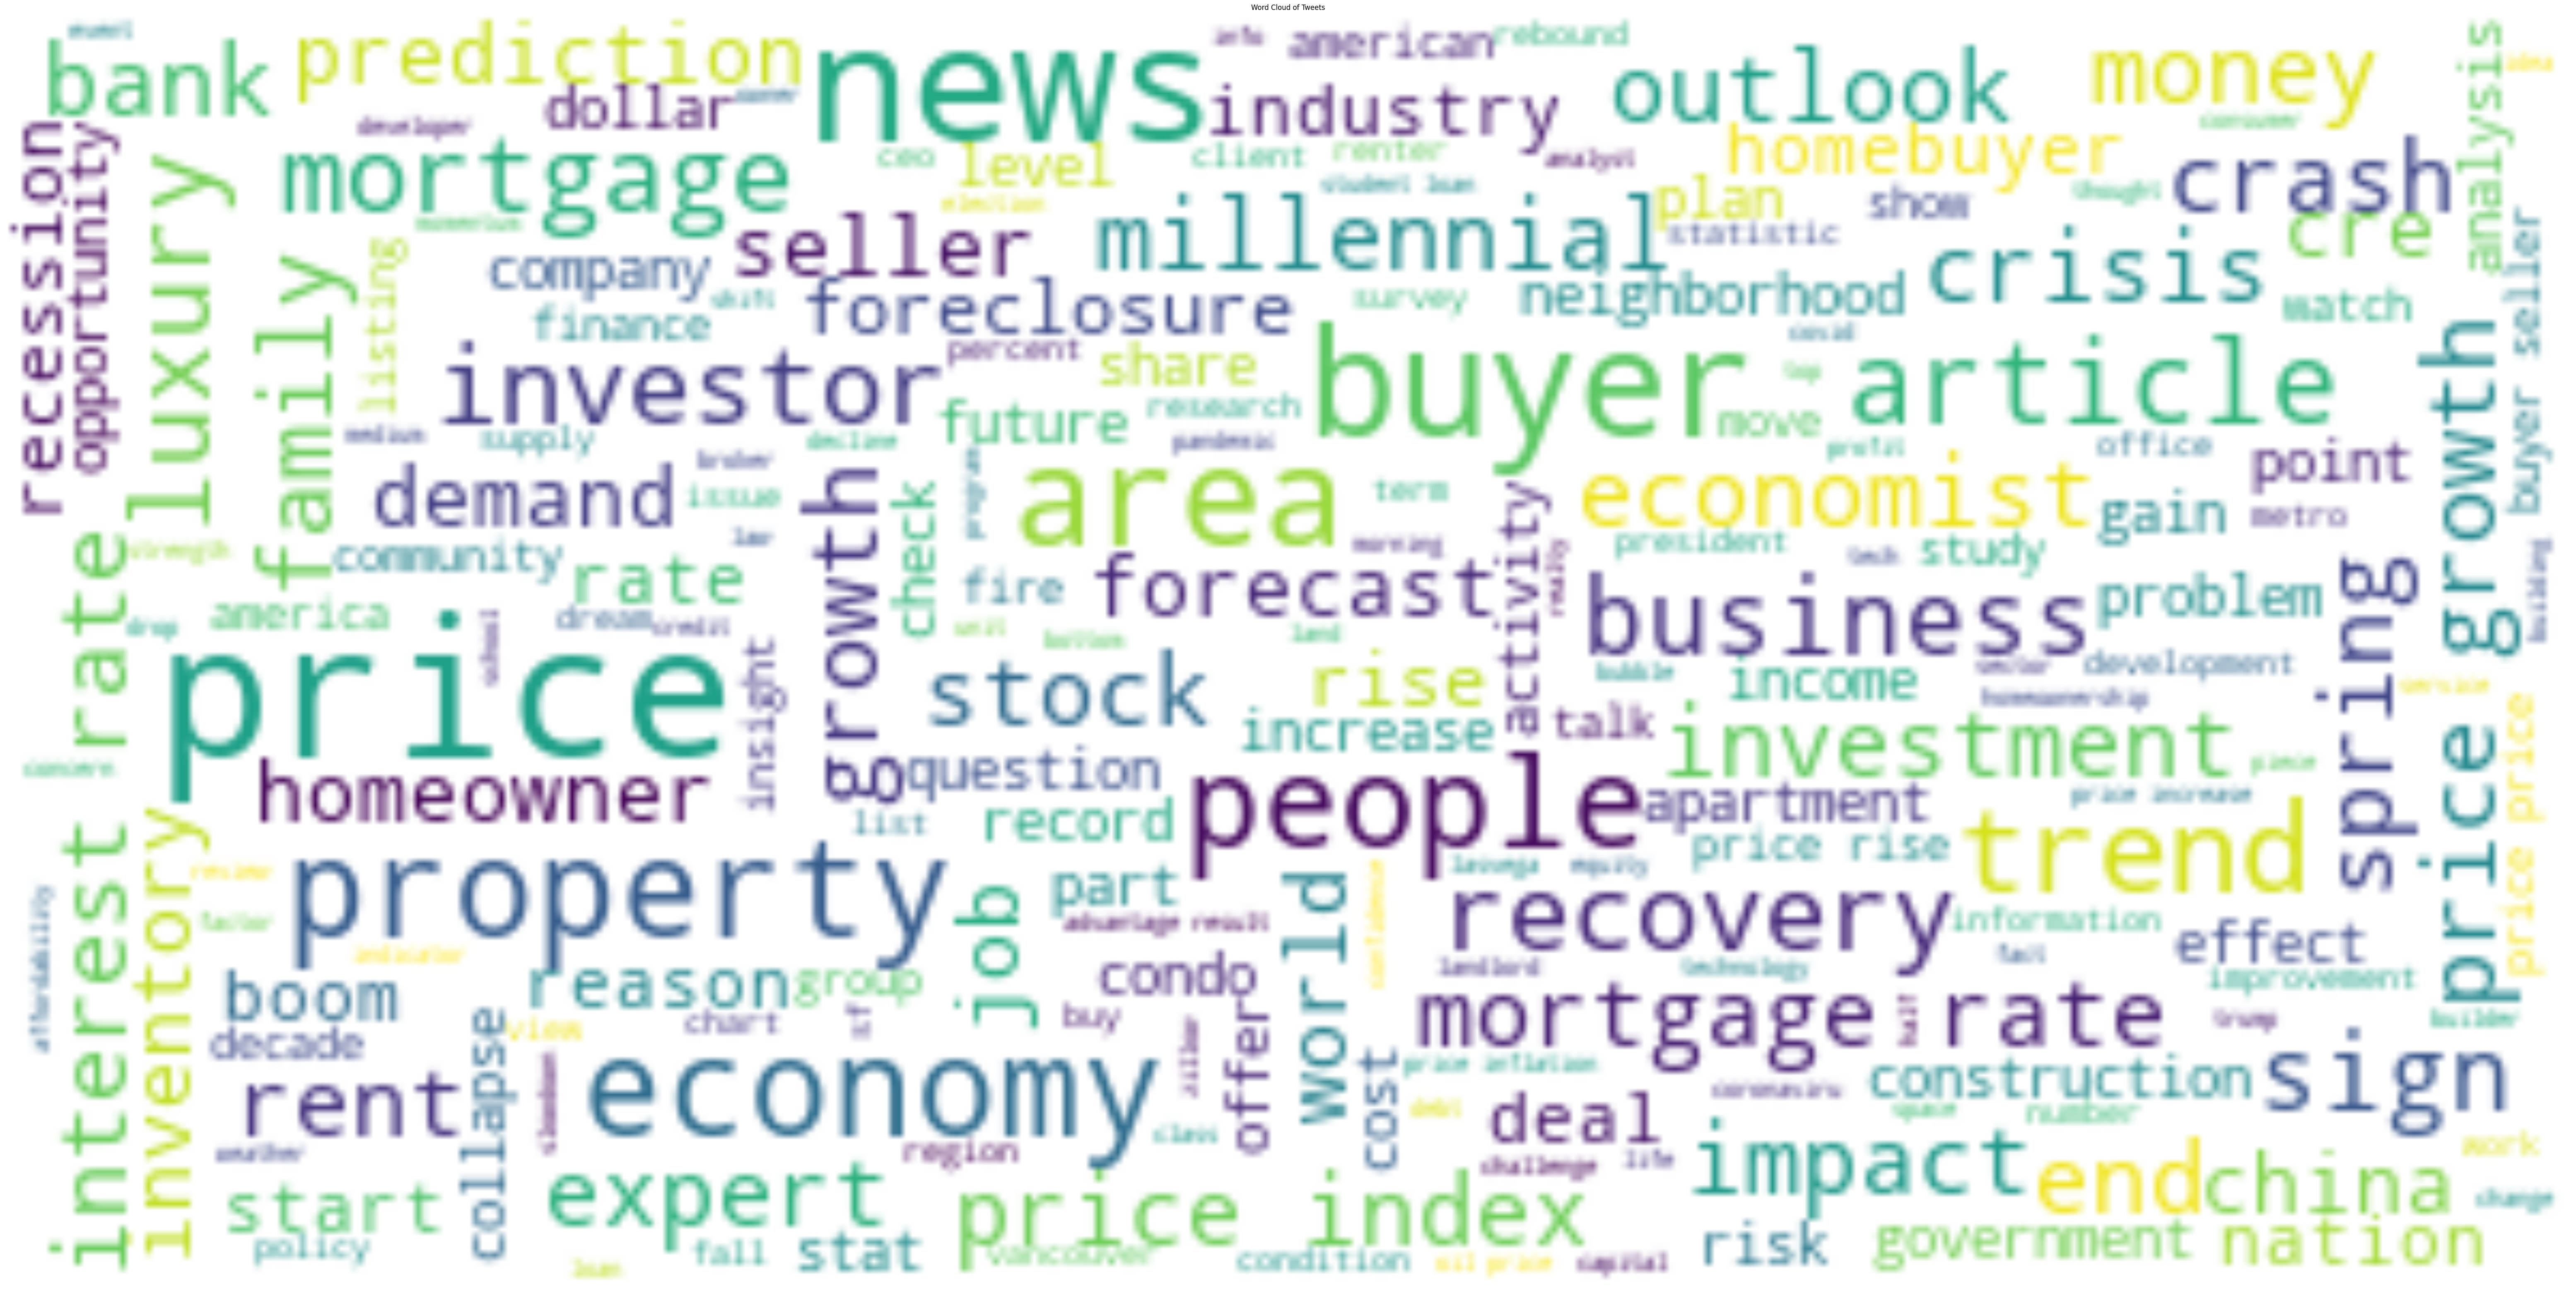

In [ ]:
#Generate the word cloud
from wordcloud import WordCloud
# Flatten the list of tokens into a single list
all_tokens = filtered_df['text'].sum()

# Join the list of tokens into a single string
all_text = ' '.join(all_tokens)

# Generate a wordcloud from the string
wordcloud = WordCloud(max_font_size=30, background_color='white').generate(all_text)
#, contour_color = 'black', contour_width = 2, color_func = lambda *args, **kwargs: 'black'
# Set the width and height of the figure
plt.figure(figsize=(80, 50))

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')

# Turn off the axis labels
plt.axis("off")

# Set the title of the plot
plt.title("Word Cloud of Tweets")

# Display the plot
plt.show()


In [ ]:
# Run LDA model
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
id2word = corpora.Dictionary(filtered_df.text)

corpus = []
for wordi in filtered_df.text:
    new = id2word.doc2bow(wordi)
    corpus.append(new)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=13,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=20)
vis


c:\Users\myloe\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\myloe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.334049 -0.357014       1        1  29.983980
6     -0.464404 -0.057500       2        1  17.032670
7     -0.408038  0.242956       3        1  15.888646
2      0.202425 -0.382727       4        1   7.559245
11    -0.033855 -0.435625       5        1   7.270033
1      0.311925  0.323447       6        1   4.653542
10     0.050380  0.424661       7        1   4.625597
3     -0.162738  0.334679       8        1   4.559571
4     -0.143718 -0.074117       9        1   3.431497
0      0.357748 -0.176631      10        1   2.662395
8      0.383478  0.052345      11        1   2.255338
5      0.120424  0.052764      12        1   0.038789
9      0.120423  0.052764      13        1   0.038697, topic_info=             Term         Freq         Total Category  logprob  loglift
33          price  14822.00000  14822.000000  Default  20.0000  20.0000
24          buyer   5283.00000   5283.000000  Default  19.0000  19.0000
126        people   4662.00000   4662.000000  Default  18.0000  18.0000
18       property   4368.00000   4368.000000  Default  17.0000  17.0000
148        demand   3001.00000   3001.000000  Default  16.0000  16.0000
..            ...          ...           ...      ...      ...      ...
15   appreciation      0.00468    400.784478  Topic13 -10.2928  -3.5008
16       investor      0.00468   2092.807032  Topic13 -10.2928  -5.1536
17             pr      0.00468      0.777856  Topic13 -10.2928   2.7439
18       property      0.00468   4368.359721  Topic13 -10.2928  -5.8895
19          world      0.00468   1017.452616  Topic13 -10.2928  -4.4324

[317 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
166       4  0.997198     access
303       4  0.998295   activity
376       4  0.997270  advantage
502       9  0.998296     advice
1208     10  0.999434  americans
...     ...       ...        ...
862       5  0.997806      woman
266       7  0.999781       work
500      11  0.995348     worker
19        7  0.999555      world
453       9  0.999904     zillow

[225 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 7, 8, 3, 12, 2, 11, 4, 5, 1, 9, 6, 10])

In [ ]:
#Export the topics and words with corresponding weights to csv file
import csv

topics = lda_model.print_topics(num_words=20)
perplexity = lda_model.log_perplexity(corpus)


with open('topics13.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Topic', 'Words', 'Weight','Perplexity','Coherence'])
    for topic in topics:
        topic_num = topic[0]+1
        topic_words = topic[1].split('+')
        for word in topic_words:
            word_data = word.split('*')
            word_weight = word_data[0]
            word_name = word_data[1]
            writer.writerow([topic_num, word_name, word_weight, perplexity])
            

In [317]:
#changing the name of the cities to be same as actual names
from fuzzywuzzy import fuzz
import pandas as pd

def replace_city_name(value, city_names, threshold):
    for city in city_names:
        ratio = fuzz.token_set_ratio(value, city)
        if ratio >= threshold:
            return city
    return value

reference_list=['washington','miami','new york','los angeles','houston','dallas','chicago','atlanta','philadelphia']
threshold = 80
filtered_df['city'] = filtered_df['author_location'].apply(lambda x: replace_city_name(x, reference_list, threshold),)
print(filtered_df.city)

5                     miami
8                washington
11            Las Vegas, NV
12          Denver Colorado
19                 new york
                ...        
551283        Las Vegas, NV
551289             new york
551308    San Francisco, CA
551310             new york
551315          los angeles
Name: city, Length: 166974, dtype: object


In [319]:
#General Sentiment Scores
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
monthly_sentiments_by_city1 = {}
for i, row in filtered_df.iterrows():
    text = row['text']
    sentiment = analyzer.polarity_scores(text)['compound']
    date = row['created_at'].to_period("M")
    city = row['city']
    if (date, city) in monthly_sentiments_by_city1:
        monthly_sentiments_by_city1[(date, city)]['weighted_sentiment_sum'] += sentiment
        monthly_sentiments_by_city1[(date, city)]['count'] += 1
    else:
        monthly_sentiments_by_city1[(date, city)] = {'weighted_sentiment_sum': sentiment, 'count': 1}
for key, value in monthly_sentiments_by_city1.items():
    monthly_sentiments_by_city1[key] = value['weighted_sentiment_sum']/value['count']


# #Sentiment-Topic Scores
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()
# monthly_sentiments_by_city_topic = {}
# for i in range(5):
#     filtered_df[f'sentiment_topic_{i}'] = 0
# for i, row in filtered_df.iterrows():
#     text = row['text']
#     sentiment = analyzer.polarity_scores(text)['compound']
#     date = row['created_at'].to_period("M")
#     city = row['city']
#     for j in range(5):
#         if row[f'topic_{j}'] > 0:
#             filtered_df.at[i, f'sentiment_topic_{j}'] = sentiment
#             weight = row[f'topic_{j}']
#             if (date, city, j) in monthly_sentiments_by_city_topic:
#                 monthly_sentiments_by_city_topic[(date, city, j)]['weighted_sentiment_sum'] += sentiment * row[f'topic_{j}']
#                 monthly_sentiments_by_city_topic[(date, city, j)]['count'] += 1
#             else:
#                 monthly_sentiments_by_city_topic[(date, city, j)] = {'weighted_sentiment_sum': sentiment * row[f'topic_{j}'], 'count': 1}

# for key, value in monthly_sentiments_by_city_topic.items():
#     monthly_sentiments_by_city_topic[key] = value['weighted_sentiment_sum']/value['count']


C:\Users\myloe\AppData\Local\Temp\ipykernel_20616\2858496773.py:8: UserWarning: Converting to Period representation will drop timezone information.
  date = row['created_at'].to_period("M")
